## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.applications.resnet50 import ResNet50

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from utils import load_data, load_3d_data

def get_data(num_training=25709, num_validation=3000, num_pub_test=1000, num_pri_test=1000):
    """
    Load the dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test = load_3d_data()
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_pub_test))
    X_pub_test = X_pub_test[mask]
    y_pub_test = y_pub_test[mask]
    mask = list(range(num_pri_test))
    X_pri_test = X_pri_test[mask]
    y_pri_test = y_pri_test[mask]

#     # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_pub_test -= mean_image
    X_pri_test -= mean_image  
    return X_train, y_train, X_val, y_val, X_pub_test, y_pub_test, X_pri_test, y_pri_test
    #return X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_pub_test, y_pub_test
   del X_pri_test, y_pri_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_pub_test, y_pub_test, X_pri_test, y_pri_test = get_data()
#X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test = get_data()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Public test data shape: ', X_pub_test.shape)
print('Public test labels shape: ', y_pub_test.shape)
print('Private test data shape: ', X_pri_test.shape)
print('Private test labels shape: ', y_pri_test.shape)

Train data shape:  (25709, 48, 48, 3)
Train labels shape:  (25709,)
Validation data shape:  (3000, 48, 48, 3)
Validation labels shape:  (3000,)
Public test data shape:  (1000, 48, 48, 3)
Public test labels shape:  (1000,)
Private test data shape:  (1000, 48, 48, 3)
Private test labels shape:  (1000,)


In [3]:
X_train[999].shape

(48, 48, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


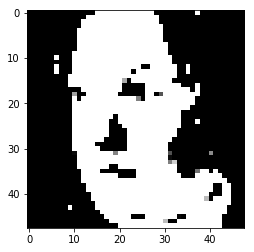

In [4]:
print(y_train[999])
plt.imshow(X_train[999]);

In [5]:
num_classes = 7

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_pub_test = keras.utils.to_categorical(y_pub_test, num_classes)
y_pri_test = keras.utils.to_categorical(y_pri_test, num_classes)

In [6]:
y_train[999]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [7]:
# As before, let's make everything float and scale
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_pub_test = X_pub_test.astype('float32')
X_pri_test = X_pri_test.astype('float32')
print(X_train.shape[1:])
X_train /= 255
X_val /= 255
X_pub_test /= 255
X_pri_test /= 255

(48, 48, 3)


In [8]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform
from keras import regularizers

def identity_block(x, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    x_shortcut = x
    x = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid',name = conv_name_base + '2a',
               kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same',name = conv_name_base + '2b',
               kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid',name = conv_name_base + '2c',
               kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2c')(x)

    #x = layers.Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x_shortcut

def convolutional_block(x, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    x_shortcut = x
    
    x = Conv2D(F1, (1,1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b',
               kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(F3, (1,1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2c')(x)
    
    x_shortcut = Conv2D(F3, (1,1), strides = (s,s), name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(x)
    x_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(x_shortcut)
    
    #x = layers.Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x_shortcut
    

input_shape = (48, 48, 3)
classes = 7

# Define the input as a tensor with shape input_shape
X_input = Input(input_shape)

# Zero-Padding
X = ZeroPadding2D((1, 1))(X_input)

# Stage 1
X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv1',)(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

# Stage 2
X = convolutional_block(X, f = 3, filters = [48, 48, 128], stage = 2, block='a', s = 1)
X = identity_block(X, 3, [48, 48, 128], stage=2, block='b')
X = identity_block(X, 3, [48, 48, 128], stage=2, block='c')

# Stage 3
#X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 1)
#X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
#X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
#X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

# Stage 4
#X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 1)
#X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
#X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
#X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
#X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
#X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

# Stage 5
#X = convolutional_block(X, f = 3, filters = [96, 96, 256], stage = 5, block='a', s = 1)
#X = identity_block(X, 3, [96, 96, 256], stage=5, block='b')
#X = identity_block(X, 3, [96, 96, 256], stage=5, block='c')

# AVGPOOL
X = AveragePooling2D((2,2), name='avg_pool')(X)

# output layer
X = Flatten()(X)

#X = Dense(100, activation='relu')(X)
#X = Dropout(0.5)(X)
#X = BatchNormalization()(X)
X = Dense(50, activation='relu', kernel_regularizer = regularizers.l2(0.03))(X)
X = Dropout(0.75)(X)

X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

# Create model
model = Model(inputs = X_input, outputs = X, name='ResNet50')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 50, 50, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 48, 64)        1792      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxP

In [9]:
rate = 1e-5

opt = keras.optimizers.Adam(lr=rate, decay=1e-6)

#Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128

print('Learning rate: %f' % rate)
loss = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=200,
              validation_data=(X_val, y_val),
              shuffle=True,
              verbose=1)
score = model.evaluate(X_pri_test, y_pri_test, verbose=0)

Learning rate: 0.000010
Instructions for updating:
Use tf.cast instead.
Train on 25709 samples, validate on 3000 samples
Epoch 1/200
25709/25709 [==============================] - 16s 605us/step - loss: 5.2909 - acc: 0.1794 - val_loss: 4.8113 - val_acc: 0.2560
Epoch 2/200
25709/25709 [==============================] - 13s 499us/step - loss: 4.8715 - acc: 0.2237 - val_loss: 4.7115 - val_acc: 0.2903
Epoch 3/200
25709/25709 [==============================] - 13s 494us/step - loss: 4.7365 - acc: 0.2473 - val_loss: 4.6118 - val_acc: 0.3080
Epoch 4/200
25709/25709 [==============================] - 13s 496us/step - loss: 4.6348 - acc: 0.2559 - val_loss: 4.5015 - val_acc: 0.3323
Epoch 5/200
25709/25709 [==============================] - 13s 498us/step - loss: 4.5307 - acc: 0.2649 - val_loss: 4.3899 - val_acc: 0.3563
Epoch 6/200
25709/25709 [==============================] - 13s 496us/step - loss: 4.4209 - acc: 0.2769 - val_loss: 4.2774 - val_acc: 0.3657
Epoch 7/200
25709/25709 [==============

25709/25709 [==============================] - 13s 497us/step - loss: 1.9459 - acc: 0.4925 - val_loss: 1.9330 - val_acc: 0.5133
Epoch 57/200
25709/25709 [==============================] - 13s 499us/step - loss: 1.9197 - acc: 0.4980 - val_loss: 1.9126 - val_acc: 0.5177
Epoch 58/200
25709/25709 [==============================] - 13s 497us/step - loss: 1.9124 - acc: 0.4954 - val_loss: 1.8984 - val_acc: 0.5197
Epoch 59/200
25709/25709 [==============================] - 13s 496us/step - loss: 1.8886 - acc: 0.5010 - val_loss: 1.8835 - val_acc: 0.5173
Epoch 60/200
25709/25709 [==============================] - 13s 496us/step - loss: 1.8808 - acc: 0.5001 - val_loss: 1.8694 - val_acc: 0.5167
Epoch 61/200
25709/25709 [==============================] - 13s 495us/step - loss: 1.8611 - acc: 0.5056 - val_loss: 1.8579 - val_acc: 0.5230
Epoch 62/200
25709/25709 [==============================] - 13s 493us/step - loss: 1.8415 - acc: 0.5098 - val_loss: 1.8478 - val_acc: 0.5230
Epoch 63/200
25709/25709 [

25709/25709 [==============================] - 13s 492us/step - loss: 1.3592 - acc: 0.5803 - val_loss: 1.4744 - val_acc: 0.5453
Epoch 115/200
25709/25709 [==============================] - 13s 490us/step - loss: 1.3512 - acc: 0.5825 - val_loss: 1.4755 - val_acc: 0.5437
Epoch 116/200
25709/25709 [==============================] - 13s 486us/step - loss: 1.3445 - acc: 0.5843 - val_loss: 1.4708 - val_acc: 0.5393
Epoch 117/200
25709/25709 [==============================] - 13s 499us/step - loss: 1.3384 - acc: 0.5859 - val_loss: 1.4719 - val_acc: 0.5420
Epoch 118/200
25709/25709 [==============================] - 13s 495us/step - loss: 1.3377 - acc: 0.5831 - val_loss: 1.4656 - val_acc: 0.5417
Epoch 119/200
25709/25709 [==============================] - 13s 492us/step - loss: 1.3321 - acc: 0.5872 - val_loss: 1.4646 - val_acc: 0.5457
Epoch 120/200
25709/25709 [==============================] - 13s 494us/step - loss: 1.3219 - acc: 0.5894 - val_loss: 1.4617 - val_acc: 0.5457
Epoch 121/200
25709/

Epoch 172/200
25709/25709 [==============================] - 13s 492us/step - loss: 1.1333 - acc: 0.6394 - val_loss: 1.3802 - val_acc: 0.5467
Epoch 173/200
25709/25709 [==============================] - 13s 491us/step - loss: 1.1305 - acc: 0.6423 - val_loss: 1.3792 - val_acc: 0.5480
Epoch 174/200
25709/25709 [==============================] - 12s 472us/step - loss: 1.1277 - acc: 0.6409 - val_loss: 1.3800 - val_acc: 0.5467
Epoch 175/200
25709/25709 [==============================] - 12s 459us/step - loss: 1.1270 - acc: 0.6425 - val_loss: 1.3755 - val_acc: 0.5487
Epoch 176/200
25709/25709 [==============================] - 12s 458us/step - loss: 1.1218 - acc: 0.6453 - val_loss: 1.3780 - val_acc: 0.5433
Epoch 177/200
25709/25709 [==============================] - 12s 470us/step - loss: 1.1286 - acc: 0.6431 - val_loss: 1.3737 - val_acc: 0.5480
Epoch 178/200
25709/25709 [==============================] - 12s 473us/step - loss: 1.1170 - acc: 0.6439 - val_loss: 1.3758 - val_acc: 0.5477
Epoch 

In [10]:
print('Learning rate:', rate)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Learning rate: 1e-05
Test loss: 1.3512535285949707
Test accuracy: 0.547


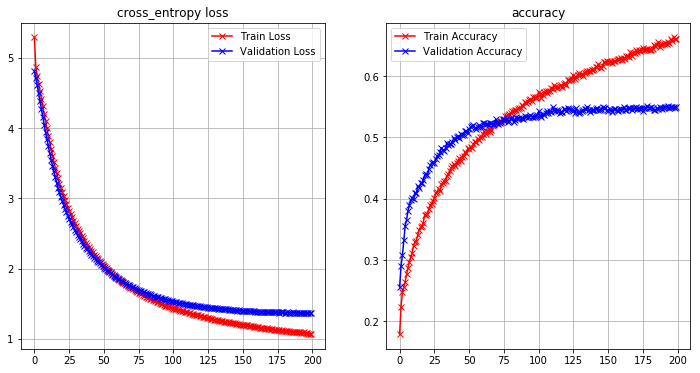

In [11]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)
    

plot_loss_accuracy(loss)

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

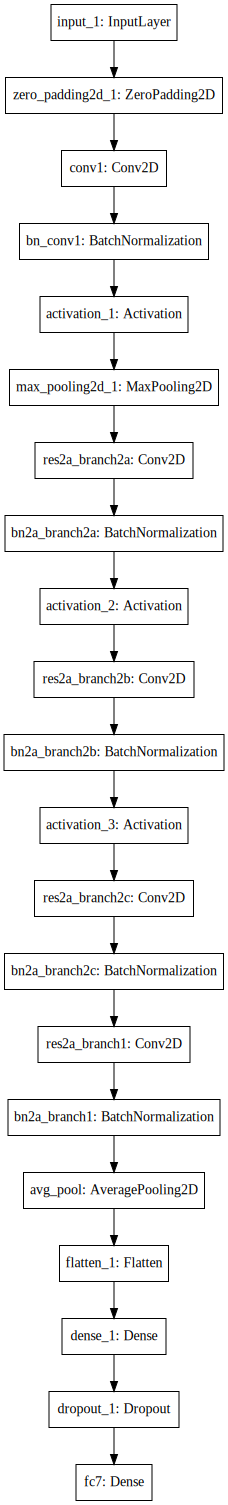

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [14]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
img_tensor = np.expand_dims(X_val[0], axis=0)
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation
classes = model.predict_classes(img_tensor, batch_size=1)
print("Predicted class is:",classes)
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

InvalidArgumentError: input_1:0 is both fed and fetched.